#  11 Compute allometry

Allometry is the relationship between size-related traits. 
- We expect to be a linear relationship between volumes of different tissues.
- Measurements are usually log-transformed as a prior step

We also compute the sphericity of the fruits
- There is no unique way to compute how sphere-like is a shape
- However, most of the common formulas are based-off the semi-axes lengths of the best-fit ellipsoid
- Check [Clayton _et al._ (2009)](https://doi.org/10.1680/geot.2007.00195) and [Blott and Pye (2008)](https://doi.org/10.1111/j.1365-3091.2007.00892.x) for more references.

The measurements for 161 different citrus fruits have already been calculated
- `data/allometry/ellipsoid_semiaxes.csv`: Semi-axes lengths of the best-fit ellipsoid of the whole fruit.
- `data/allometry/citrus_sizes.csv`: Volume (in voxel number) of the main tissues of the fruit
- `data/citrus_voxel_size.csv`: Size of voxel for each scan

<img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/exocarp_vs_endocarp.jpg" width=700>

In [1]:
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import textwrap

from scipy import special

import warnings
warnings.filterwarnings( "ignore")

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

### Load the data

- Load semi-axes length and volume information for each fruit.

In [2]:
src = '../data/allometry/'
oil_src = '../data/oil/'

semiaxes = pd.read_csv(src + 'ellipsoid_semiaxes.csv').values
data = pd.read_csv(src + 'citrus_sizes.csv')
bnames = data.citrus_id

dst = '../data/merged/'
if not os.path.isdir(dst):
    os.makedirs(dst)

### Compute various sphericity indices for all the fruits

- Also compute the volume and surface area of the best-fit ellipsoid.

In [3]:
a,b,c = 1/(semiaxes**2).T
I = a + b + c
J = a*b + b*c + c*a
rho = (4*J - I*I)/(a**2 + b**2 + c**2)
rho = (rho + 1)*.5

#######

c, b, a = np.sort(semiaxes, axis=1).T

krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(b*a))
equancy = c/a
janke = c/(np.sqrt((a**2 + b**2 + c**2)/3))
p = c/b
q = b/a
aschenbrenner = (3+6*np.sqrt(3))*np.cbrt(p*p*q)/(1+p*(1+q)+6*np.sqrt(1+p*p*(1+q*q)))

sphere = (a == b) & (b == c)

t = np.arccos(c/a)
s = np.arccos(c/b)
k = np.sin(s)/np.sin(t)

area = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
area *= 2*np.pi*a*b/np.sin(t)
area += 2*np.pi*c*c
area[sphere] = 4*np.pi*a[sphere]*a[sphere]

volume = 4*np.pi*a*b*c/3

wadell = np.cbrt(36*np.pi*volume*volume)/area

### Load voxel-size data

- The micron size of each voxel depends on the scanning parameters.

In [4]:
voxel_filename = '../data/citrus_voxel_size.csv'
voxel_size = pd.read_csv(voxel_filename)
voxsize = np.zeros(len(data.citrus_id))
for i,bname in enumerate(data.citrus_id):
    voxsize[i] = (voxel_size.loc[voxel_size.ID == bname, 'voxel_size_microns'].values)[0]
data.iloc[:,2:-1] = 1e-12*data.iloc[:,2:-1]*(voxsize**3).reshape(-1,1)

### Split fruits into groups of interest

- See attached supplementary S1
- Results stored in a dictionary

In [5]:
citrus_names = ['Lemons and Lemon Hybrids', 'Mandarins and Mandarin Hybrids', 'Pummelos and Pummelo Hybrids', 
                'Sour Oranges and their hybrids', 'Sweet Oranges', 'Papedas', 'Trifoliates and Trifoliate Hybrids',
                'Microcitrus', 'Kumquats', 'Other']
citrus_ss = [[] for i in range(len(citrus_names))]

for i in range(len(bnames)):
    bname = bnames[i]
    if bname[0] == 'C':
        if int(bname[1:3]) in [6,7,8]:
            citrus_ss[-1].append(i)
        else:
            citrus_ss[0].append(i)
    elif bname[0] == 'M':
        if int(bname[1:3]) in [6]:
            citrus_ss[-1].append(i)
        else:
            citrus_ss[1].append(i)
    elif bname[0] == 'P':
        if int(bname[1:3]) in [7]:
            citrus_ss[-1].append(i)
        else:
            citrus_ss[2].append(i)
    elif bname[:2] == 'SR':
        citrus_ss[3].append(i)
    elif bname[:2] == 'SW':
        citrus_ss[4].append(i)
    else:
        foo = int(bname[2:4])
        if foo in [9,12,17]:#[19,7,5]:#[9,12,17]:
            citrus_ss[5].append(i)
        elif foo in [4,10,13,18]:#[4,10,13,18,16]:
            citrus_ss[6].append(i)
        elif foo == 6:
            citrus_ss[-1].append(i)
        elif foo in [8]:
            citrus_ss[7].append(i)
        elif foo in [2]:
            citrus_ss[8].append(i)
        else:
            citrus_ss[-1].append(i)

for i in range(len(citrus_ss)):
    citrus_ss[i] = np.asarray(citrus_ss[i])

citrus_dict = dict(zip(citrus_names, citrus_ss))
citrus_vect = np.empty(len(bnames), dtype='<U60')
for key in citrus_dict:
    citrus_vect[citrus_dict[key]] = key

### Merge all the measurements into a single table

- Also compute oil gland density across fruit volume and surface area
- Get appropriate plot labels for each measurement.

In [6]:
data['wadell'] = wadell
data['krumbein'] = krumbein
data['corey'] = corey
data['sneed'] = sneed
data['janke'] = janke
data['equancy'] = equancy

data['rho'] = rho

data['area'] = area
data['volume'] = volume

data['density_whole'] = data['num_glands']/data['whole']
data['density_exocarp'] = data['num_glands']/data['exocarp']
data['density_area'] = data['num_glands']/area
data['density_volume'] = data['num_glands']/volume


data['kind'] = citrus_vect

In [7]:
collabs = data.columns.values.copy()
collabs = [str.title(collabs[i].replace('_',' ')) for i in range(len(collabs))]
for i in range(2,9):
    collabs[i] = 'log Vol('+collabs[i]+') [cm$^3$]'
for i in range(19,23):
    if i == 21:
        collabs[i] = 'log ('+collabs[i]+') [glands/cm$^2$]'
    else:
        collabs[i] = 'log ('+collabs[i]+') [glands/cm$^3$]'
collabs[9] = 'log Num of Glands'
collabs[13] = 'Sneed & Folk'
for i in range(10,17):
    collabs[i] = collabs[i] + ' index'
collabs[17] = 'log (Ellipsoidal Area) [cm$^2$]'
collabs[18] = 'log (Ellipsoidal Vol) [cm$^3$]'
for i,c in enumerate(collabs):
    print(i,'\t',c)

0 	 Citrus Id
1 	 Label
2 	 log Vol(Whole) [cm$^3$]
3 	 log Vol(Exocarp) [cm$^3$]
4 	 log Vol(Endocarp) [cm$^3$]
5 	 log Vol(Rind) [cm$^3$]
6 	 log Vol(Spine) [cm$^3$]
7 	 log Vol(Mesocarp) [cm$^3$]
8 	 log Vol(Oil Glands) [cm$^3$]
9 	 log Num of Glands
10 	 Wadell index
11 	 Krumbein index
12 	 Corey index
13 	 Sneed & Folk index
14 	 Janke index
15 	 Equancy index
16 	 Rho index
17 	 log (Ellipsoidal Area) [cm$^2$]
18 	 log (Ellipsoidal Vol) [cm$^3$]
19 	 log (Density Whole) [glands/cm$^3$]
20 	 log (Density Exocarp) [glands/cm$^3$]
21 	 log (Density Area) [glands/cm$^2$]
22 	 log (Density Volume) [glands/cm$^3$]
23 	 Kind


### Sort the key order in the citrus group dictionary

- Define different markers and colors for each group

In [8]:
keys = sorted(list(citrus_dict.keys()))

keys = [keys[i] for i in list(range(4)) + list(range(5,len(keys))) + [4]]

marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']

# Color palettes are meant to be colorblind friendly

col_wong = ['#000000', '#e69f00', '#56b4e9', '#009e73', '#f0e442', '#0072b2', '#d55e00', '#cc79a7']
col_wong = ['#000000', '#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']
fs = 25

In [9]:
for i,c in enumerate(data.columns):
    print(i,'\t',c)

0 	 citrus_id
1 	 label
2 	 whole
3 	 exocarp
4 	 endocarp
5 	 rind
6 	 spine
7 	 mesocarp
8 	 oil_glands
9 	 num_glands
10 	 wadell
11 	 krumbein
12 	 corey
13 	 sneed
14 	 janke
15 	 equancy
16 	 rho
17 	 area
18 	 volume
19 	 density_whole
20 	 density_exocarp
21 	 density_area
22 	 density_volume
23 	 kind


../data/allometry/glands_panel_allometry


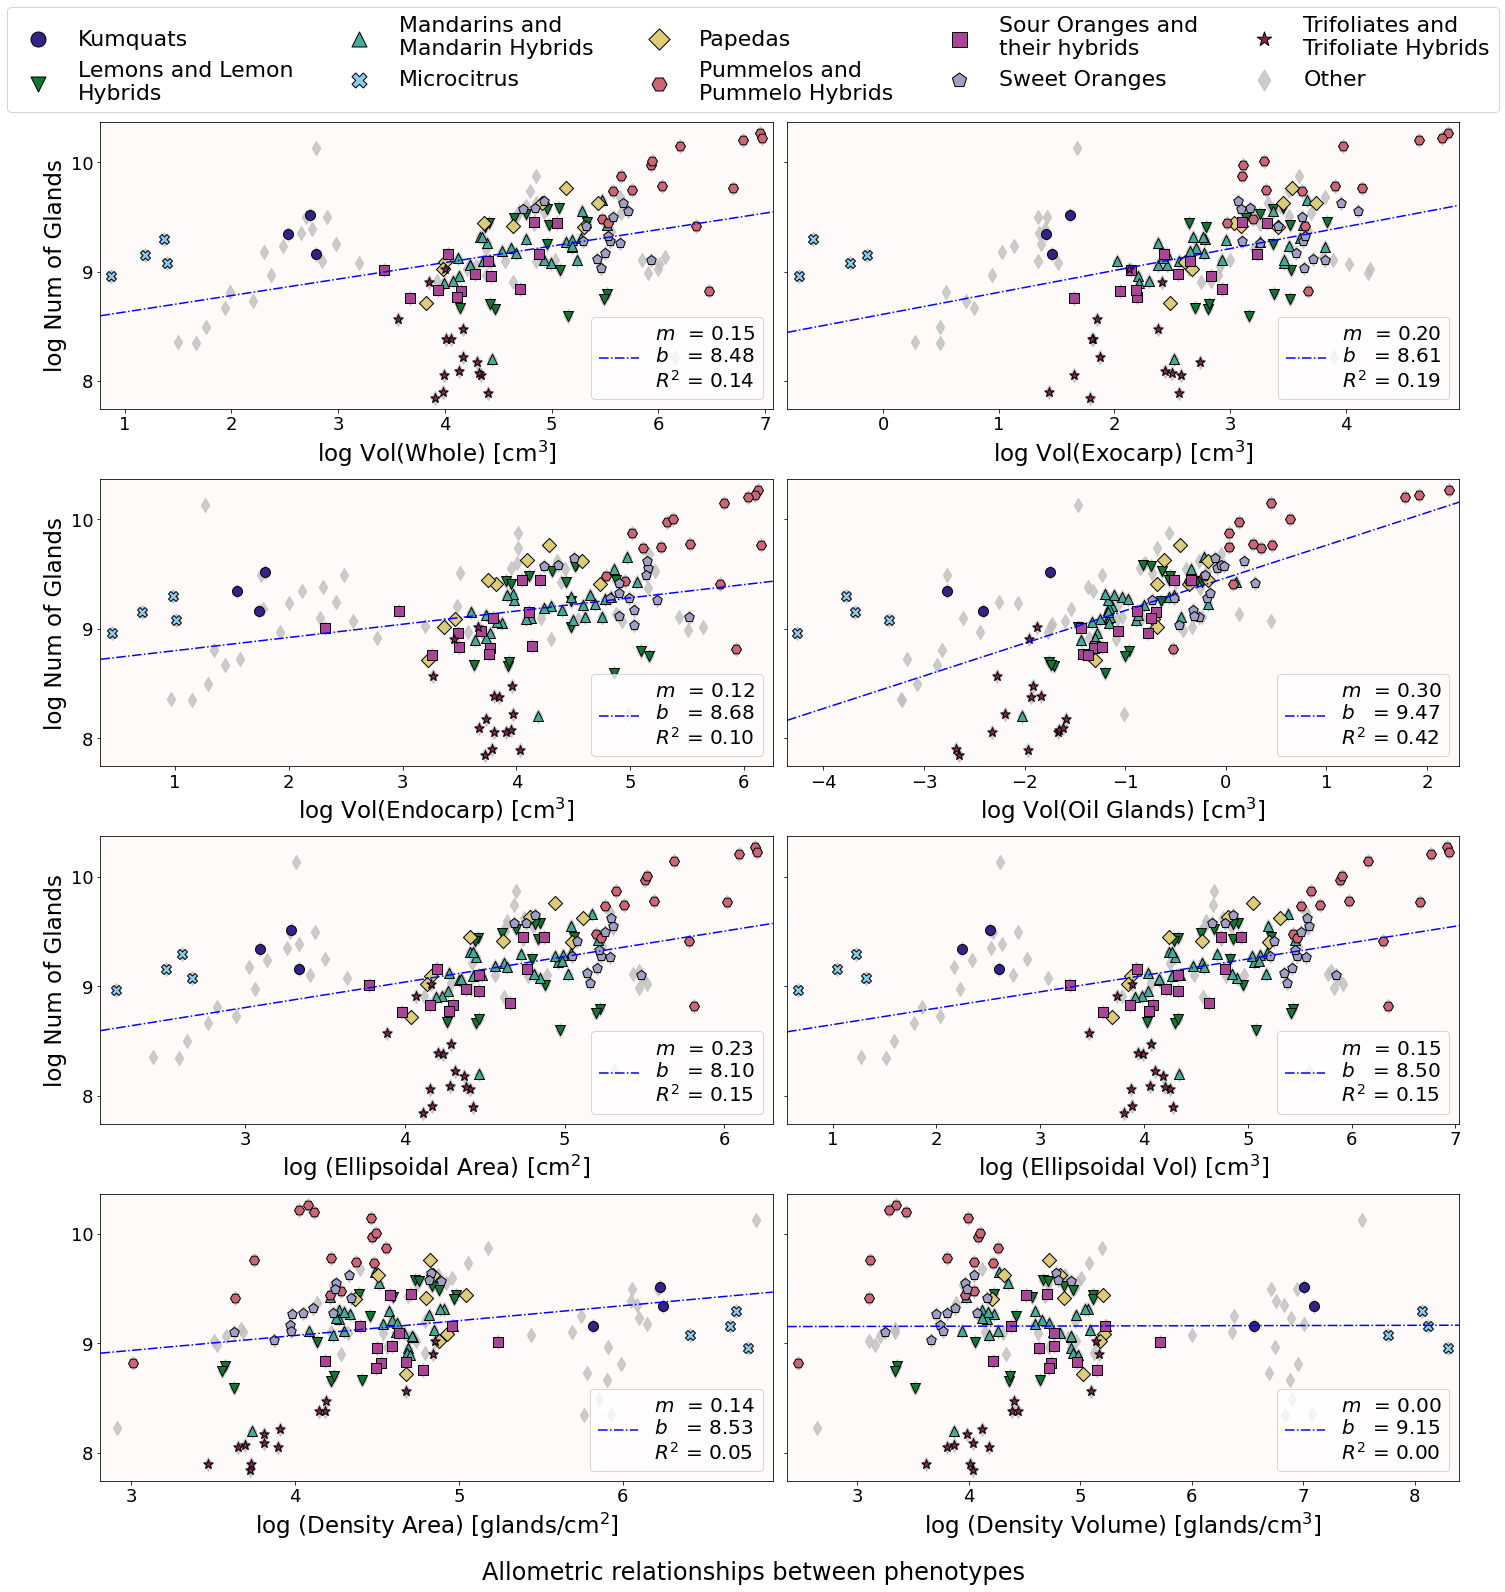

In [10]:
fig, ax = plt.subplots(4,2, figsize=(20,20), sharey=True)
ax = ax.ravel()

for idx,foo in enumerate([(2,9), (3,9), (4,9), (8,9), (17,9), (18,9), (21,9), (22,9)]):
    i,j = foo
    trait_i = np.log(data.iloc[:,i].values)
    trait_j = np.log(data.iloc[:,j].values)
    ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=15)
    new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
    foo = new_series.convert().coef
    r2 = r2_score(trait_j, new_series(trait_i))
    bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='b', label='r', ls='-.')
    ax[idx].legend([bar], ['$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], foo[0], r2)], 
                   loc='lower right', fontsize=20)
    ax[idx].scatter(trait_i, trait_j, alpha=0.8,
               s=100, marker='d', color='silver', label='Other')
    ax[idx]
    for k in range(len(keys)-1):
        xx = trait_i[citrus_dict[keys[k]]]
        yy = trait_j[citrus_dict[keys[k]]]
        ax[idx].scatter(xx, yy, alpha=1,
                   s=100, marker=marker[k], color=col_tol[k], label=keys[k],
                       edgecolor='k', linewidth=1)
        h, l = ax[idx].get_legend_handles_labels()
    ax[idx].set_xlabel(collabs[i], fontsize=23)
    ax[idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[idx].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[idx].tick_params(labelsize=18)
for idx in [0,2,4]:
    ax[idx].set_ylabel(collabs[j], fontsize=23)

ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]
fig.legend(hh, ll,
           fontsize=22, markerscale = 1.5, 
           loc='upper center', fancybox=True, ncol=5, bbox_to_anchor=(0.5, 1.08));

fig.text(0.5, -0.02, 'Allometric relationships between phenotypes', ha='center', fontsize=24)
fig.tight_layout();

filename = src + 'glands_panel_allometry'
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(filename + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

../data/allometry/panel_allometry


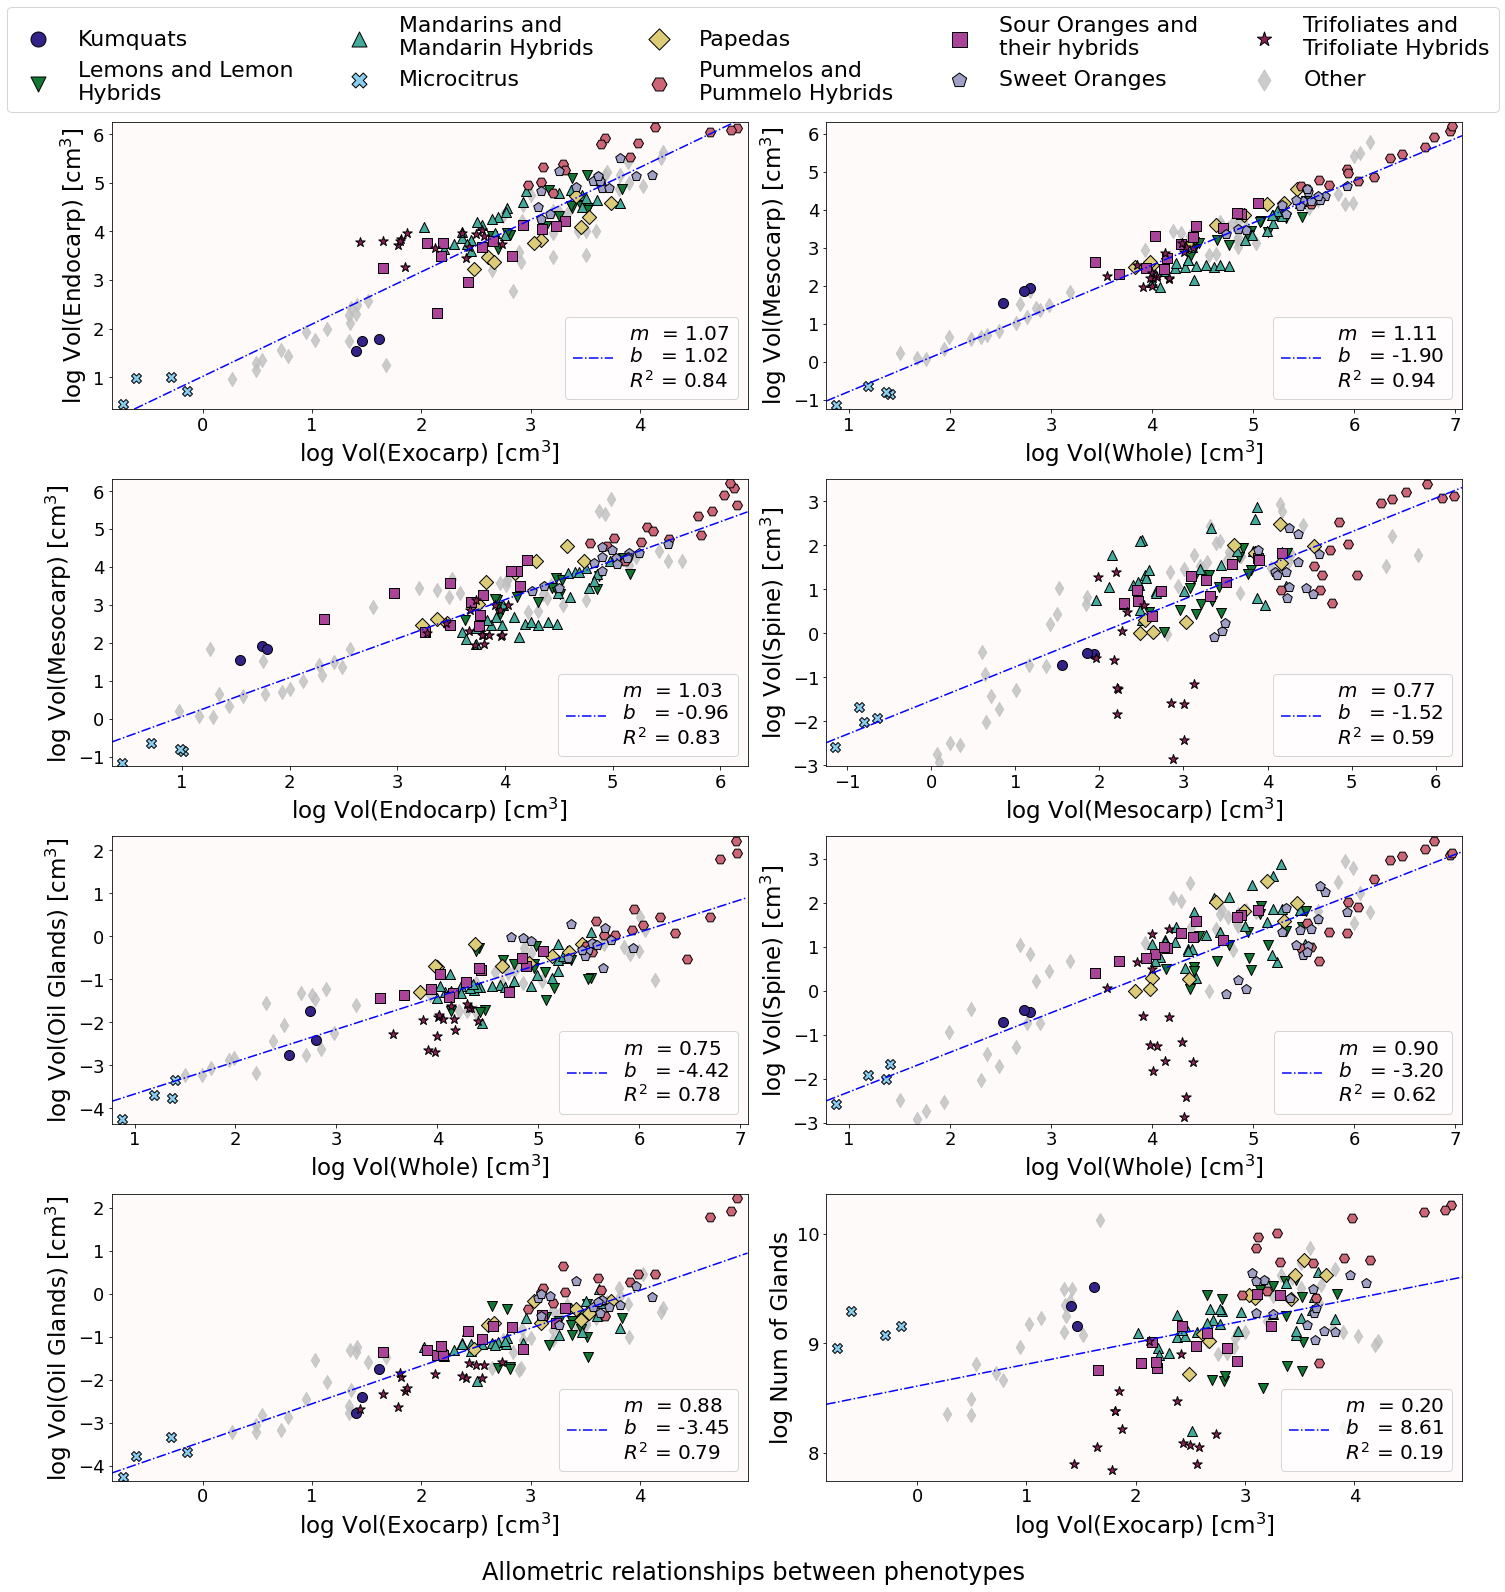

In [11]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
ax = ax.ravel()

for idx,foo in enumerate([(3,4), (2,7), (4,7), (7,6), (2,8), (2,6), (3,8), (3,9)]):
    i,j = foo
    trait_i = np.log(data.iloc[:,i].values)
    trait_j = np.log(data.iloc[:,j].values)
    ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=15)
    new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
    foo = new_series.convert().coef
    r2 = r2_score(trait_j, new_series(trait_i))
    bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='b', label='r', ls='-.')
    ax[idx].legend([bar], ['$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], foo[0], r2)], 
                   loc='lower right', fontsize=20)
    
    xx = trait_i[citrus_dict[keys[-1]]]
    yy = trait_j[citrus_dict[keys[-1]]]
    ax[idx].scatter(xx, yy, alpha=0.8,
               s=100, marker='d', color='silver', label='Other')
    
    for k in range(len(keys)-1):
        xx = trait_i[citrus_dict[keys[k]]]
        yy = trait_j[citrus_dict[keys[k]]]
        ax[idx].scatter(xx, yy, alpha=1,
                   s=100, marker=marker[k], color=col_tol[k], label=keys[k],
                       edgecolor='k', linewidth=1)
        h, l = ax[idx].get_legend_handles_labels()
    ax[idx].set_xlabel(collabs[i], fontsize=23)
    ax[idx].set_ylabel(collabs[j], fontsize=23)
    ax[idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[idx].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[idx].tick_params(labelsize=18)


ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]
fig.legend(hh, ll,
           fontsize=22, markerscale = 1.5, 
           loc='upper center', fancybox=True, ncol=5, bbox_to_anchor=(0.5, 1.08));

fig.text(0.5, -0.02, 'Allometric relationships between phenotypes', ha='center', fontsize=24)
fig.tight_layout();
fig.set_alpha(0)

filename = src + 'panel_allometry'
print(filename)
#plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
plt.savefig(filename + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

## Save the compiled measurement data

In [14]:
filename = src + 'volumes_and_sphericities.csv'
df = data[[data.columns[i] for i in [0,1] + [len(collabs)-1] + list(range(2,len(collabs)-1))]]
df.to_csv(filename, index = False)
df.head()

,citrus_id,label,kind,whole,exocarp,endocarp,rind,spine,mesocarp,oil_glands,...,sneed,janke,equancy,rho,area,volume,density_whole,density_exocarp,density_area,density_volume
0,C01_CRC2317_18B-18-9,L00,Lemons and Lemon Hybrids,160.687610,34.104516,88.077546,47.450018,6.902806,40.547212,0.228940,...,0.951930,0.950575,0.912011,0.991301,131.552197,141.634935,51.136488,240.935831,62.461899,58.015348
1,C01_CRC2317_18B-18-9,L01,Lemons and Lemon Hybrids,86.992947,16.597155,50.561608,26.259460,3.501201,22.758259,0.180907,...,0.983618,0.983413,0.965487,0.998762,85.078009,73.772020,66.304226,347.529450,67.796603,78.186825
2,C01_CRC2317_18B-18-9,L02,Lemons and Lemon Hybrids,82.898044,16.715139,51.140166,20.911448,1.698778,19.212670,0.172182,...,0.951965,0.950623,0.912486,0.991368,86.859773,75.990242,72.438380,359.255168,69.134419,79.023304
3,C01_CRC2317_18B-18-9,L03,Lemons and Lemon Hybrids,62.717743,14.892982,37.671975,14.998806,1.627702,13.371095,0.175542,...,0.962920,0.962225,0.940127,0.995483,70.871279,56.052537,92.748873,390.586653,82.078383,103.777639
4,C02_CRC3919_18A-24-1,L00,Lemons and Lemon Hybrids,103.970975,23.082609,61.024476,26.689248,1.951175,24.738073,0.573769,...,0.952981,0.949677,0.878024,0.981572,100.580813,94.474523,126.814238,571.209261,131.088620,139.561435


# References

- **Blott, SJ**, **Pye, K** (2008) Particle shape: a review and new methods of characterization and classification. _Sedimentology_ **55**(1), 31-63. [DOI: 10.1111/j.1365-3091.2007.00892.x](https://doi.org/10.1111/j.1365-3091.2007.00892.x)

- **Clayton, CRI**, **Abbireddy, COR**, **Schiebel, R** (2009) A method of estimating the form of coarse particulates. _Géotechnique_ **59**(6), 493-501. [DOI: 10.1680/geot.2007.00195](https://doi.org/10.1680/geot.2007.00195)